# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

---

Looks at IV lead of 9 months, HO lag of 3 months forward

- Using year, month, county as fixed effects. But interact year_trend * month_county.
- Include control diagnoses.

In [3]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [2]:
# download this extra package from here: https://github.com/bashtage/linearmodels
#!pip install linearmodels
# from linearmodels.iv import IV2SLS as IV2SLS_v2

In [7]:
data_path = 'I:\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data\\'

In [6]:
# decide whether to save results:
save_results = False
# decide whether to delete old dataframes from memory when we get to modeling
clean_memory = True

# Read in data

In [59]:
# read in our modeling data
df = pd.read_parquet(os.path.join(data_path, 'modeling_data\\modeling_data_joined_11-9.parquet'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]
df4 = pd.read_csv(os.path.join(data_path, 'medical/resp_cardio.csv')).iloc[:,1:]
df5 = pd.read_csv(os.path.join(data_path, 'medical/injuries_accidents.csv')).iloc[:,1:]

In [10]:
# check if rolling columns are already there for pm25
df[['year_month', 'school_zip', 'pm25', 'pm25_last_month','pm25_r6','pm25_r9','pm25_r12','pm25_r24']][df.school_zip == 90001].head(25)

,year_month,school_zip,pm25,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24
index,,,,,,,,
0,2000-01-01,90001,32.149998,NaN,NaN,NaN,NaN,NaN
1322,2000-02-01,90001,13.666667,32.149998,NaN,NaN,NaN,NaN
2644,2000-03-01,90001,17.183334,13.666667,NaN,NaN,NaN,NaN
3966,2000-04-01,90001,17.366667,17.183334,NaN,NaN,NaN,NaN
5288,2000-05-01,90001,17.616667,17.366667,NaN,NaN,NaN,NaN
6611,2000-06-01,90001,16.883333,17.616667,NaN,NaN,NaN,NaN
7934,2000-07-01,90001,18.850000,16.883333,19.144444,NaN,NaN,NaN
9258,2000-08-01,90001,18.833332,18.850000,16.927778,NaN,NaN,NaN
10582,2000-09-01,90001,17.766666,18.833332,17.788889,NaN,NaN,NaN


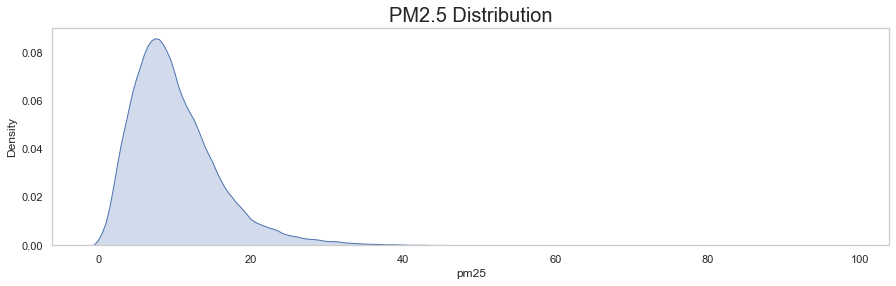

In [11]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="pm25", bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Distribution", size=20)
print('')

In [12]:
def kde_multiple_plotter(col_list:list, title_str:str, value_name_str:str, df_plot, clip_tuple:tuple = None, log_scale_value=False):
    """plots several KDE plots from column of a dataframe.

    Args:
        col_list (list): list of columns to plot, must be in df_plot
        title_str (str): title of plot
        value_name_str (str): x axis value name
        df_plot (pandas dataframe): dataframe
        clip_tuple (tuple, optional): range of x axis values to plot. Defaults to None.
    """

    if log_scale_value:
        s = '(Log)'
    else:
        s = ''

    df_melt = pd.melt(df_plot, 
              value_vars=col_list, 
              var_name='measure', value_name=value_name_str)
    sns.set(rc = {'figure.figsize':(15,4)}) 
    sns.set_style("whitegrid", {'axes.grid' : False})

    sns.kdeplot(data=df_melt, x=value_name_str, hue='measure', bw_adjust=.8, fill=True, clip=clip_tuple, log_scale=log_scale_value)\
    .set_title(title_str+s, size=20)
    print('')


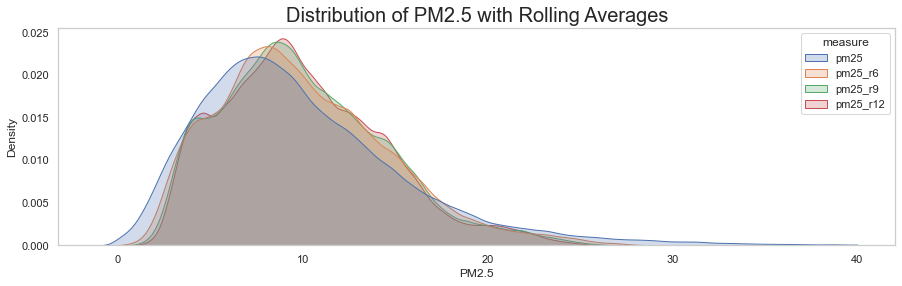

In [13]:
rolling_pm25_cols = ['pm25', 'pm25_r6','pm25_r9','pm25_r12']
title_str = 'Distribution of PM2.5 with Rolling Averages'
name_str = 'PM2.5'
clip_tuple_val=(-5, 40.0)

kde_multiple_plotter(col_list = rolling_pm25_cols, title_str = title_str, value_name_str = name_str, df_plot=df, clip_tuple=clip_tuple_val)

# Data clean

Create Rolling Features for Stage 1 Regression:

- `'pm25'`: last month, average of past 6 months, 9months, 12 months
    - already made above as `'pm25_last_month','pm25_r6','pm25_r9','pm25_r12'`
- `'avg_wind_alignment'`: last month, average of past 6 months, 9 months, 12 months
- `'avg_wind_alignment_cosine'` (transforming `avg_wind_alignment`): last month, average of past 6 months, 9 months, 12 months

In [62]:
# filter out rows with no values for new instrument calculations

df = df[~df['schools'].isnull()]

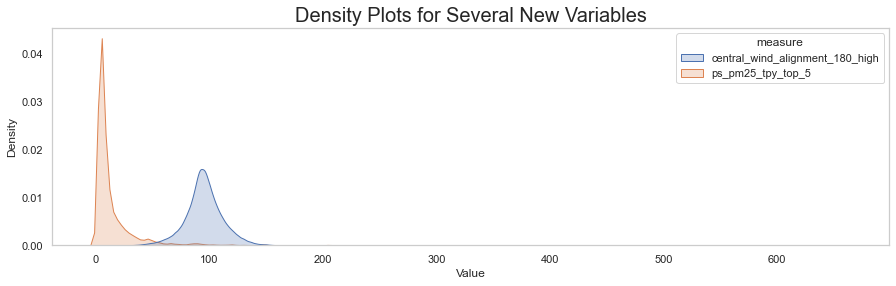

In [24]:
# avg_wind_alignment

kde_multiple_plotter(col_list = ['central_wind_alignment_180_high','ps_pm25_tpy_top_5'], title_str = 'Density Plots for Several New Variables', value_name_str = 'Value', df_plot=df)

In [11]:
# initial count of nulls
df.isna().sum()[df.isna().sum() > 0]

pm25_last_month     1387
pm25_r6             8322
pm25_r9            12483
pm25_r12           16644
pm25_r24           33288
pm25_slope6         8322
pm25_slope9        12483
pm25_slope12       16644
pm25_slope24       33288
pm25_lag_12mo      16644
dtype: int64

In [21]:
# Sort the dataframe by school zip and year_month ascending so we can use rolling values in order of year_month

# convert to date time object
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df = df.sort_values(['school_zip', 'year_month'])

df.head(5)

,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,avg_wspd_top_5,avg_u,avg_v,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,0.757031,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1322,2000-02-01,90001,Los Angeles,Los Angeles County,13.666667,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.965276,30.294778,30.294778,120.491364,120.491364,0.965276,120.491364,0.547186,0.0,0.965276,20049.704556,2608176.0,47.87313,13.877778,13.866667,9,32.149998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,2,0,0,0,0,0,0,0,0,0,0,

In [25]:
# get rolling n month avg
def create_rolling_avg(df, var_name:str = 'pm25', num_months=6):
  """create rolling average of a variable for a number of months specified. Closed on current, so the current month is NOT included.

  Make sure that dataframe is sorted by school zipcode and year_month before running this.
  df = df.sort_values(['school_zip', 'year_month'])


  Args:
      df (_type_): dataframe to add columns to
      var_name (str, optional): column name to make rolling average of. Defaults to 'pm25'.
      num_months (int, optional): number of months to take average of. done using . Defaults to 6.

  Returns:
      _type_: _description_
  """
  df[f'{var_name}_r{num_months}'] = df.groupby('school_zip')[var_name]\
    .apply(lambda x: x.rolling(window=num_months, min_periods=num_months, closed='left').mean())
    
  return df 

## Create and compare rolling averages for each instrument

In [49]:
cols_to_roll = ['Izmy_v1_unnormed',
'Izmy_v2_nodist_unnormed',
'Izmy_v3_normed_D_and_TPY',
'Izmy_v4_nodist_normed_TPY',
'Izmy_v5_all_normed']

all_cols = []

col_index = 0

In [51]:
# last month's Named column

col_to_roll = cols_to_roll[col_index]
rolling_periods = [1, 6, 9, 12]
new_cols = []

for period in rolling_periods:
    df = create_rolling_avg(df, var_name=col_to_roll, num_months=period)
    new_cols.append(col_to_roll + "_r" + str(period))
    
all_cols.append([col_to_roll] + new_cols)    

In [31]:
base_cols = ['year_month', 'school_zip', 'pm25', 'pm25_last_month', 'pm25_r6','pm25_r9','pm25_r12','avg_wind_alignment']

show_cols = base_cols + new_cols

df[show_cols].head(20)

,year_month,school_zip,pm25,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,avg_wind_alignment,Izmy_v1_unnormed_r1,Izmy_v1_unnormed_r6,Izmy_v1_unnormed_r9,Izmy_v1_unnormed_r12
index,,,,,,,,,,,,
15881,2001-01-01,90001,28.900000,37.000000,24.175000,21.879629,21.659722,49.721438,NaN,NaN,NaN,NaN
17242,2001-02-01,90001,12.150000,28.900000,25.850000,23.161111,21.388889,73.451102,1879.881015,NaN,NaN,NaN
18603,2001-03-01,90001,20.116667,12.150000,24.736111,22.553703,21.262500,117.082993,1888.740848,NaN,NaN,NaN
19964,2001-04-01,90001,17.533333,20.116667,25.127778,22.912963,21.506944,153.335420,1246.459005,NaN,NaN,NaN
21325,2001-05-01,90001,21.066666,17.533333,24.138889,22.766666,21.520833,137.890809,1104.839160,NaN,NaN,NaN
22686,2001-06-01,90001,16.383333,21.066666,22.794444,23.014815,21.808333,132.439880,923.125607,NaN,NaN,NaN
24047,2001-07-01,90001,18.900000,16.383333,19.358333,22.861111,21.766666,127.307537,876.609548,1319.942531,NaN,NaN
25409,2001-08-01,90001,19.516666,18.900000,17.691667,22.353704,21.770833,126.771547,802.397672,1140.361974,NaN,NaN
26771,2001-09-01,90001,17.650000,19.516666,18.919444,21.285185,21.827778,138.529593,811.775758,960.867792,NaN,NaN


In [32]:
# count of nulls after adding rolling IVs
df.isna().sum()[df.isna().sum() > 0]

pm25_last_month            62
pm25_r6                   375
pm25_r9                   568
pm25_r12                  763
pm25_r24                17407
pm25_slope6               375
pm25_slope9               568
pm25_slope12              763
pm25_slope24            17407
pm25_lag_12mo             763
Izmy_v1_unnormed_r1      1387
Izmy_v1_unnormed_r6      8322
Izmy_v1_unnormed_r9     12483
Izmy_v1_unnormed_r12    16644
dtype: int64

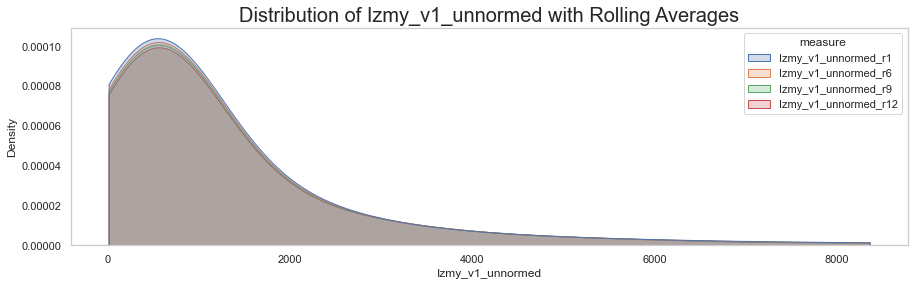

In [42]:
title_str = 'Distribution of ' + col_to_roll + ' with Rolling Averages'
name_str = col_to_roll
low_end = df[new_cols].min().min()
high_end = df[new_cols].max().max()

clip_tuple_val=(low_end, high_end/100)

kde_multiple_plotter(col_list=new_cols, title_str=title_str, value_name_str=name_str, df_plot=df, clip_tuple=clip_tuple_val)

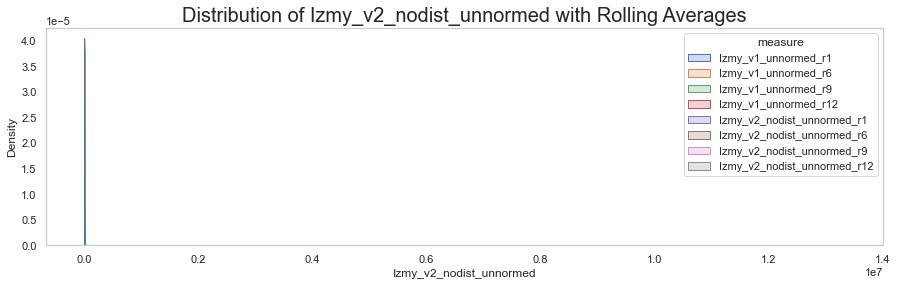

In [53]:
# Roll and print next instrument

col_index += 1

col_to_roll = cols_to_roll[col_index]
rolling_periods = [1, 6, 9, 12]

for period in rolling_periods:
    df = create_rolling_avg(df, var_name=col_to_roll, num_months=period)
    new_cols.append(col_to_roll + "_r" + str(period))
    
all_cols.append([col_to_roll] + new_cols)

show_cols = base_cols + new_cols

# show df
# df[show_cols].head(20)

# count of nulls after adding rolling IVs
# df.isna().sum()[df.isna().sum() > 0]

title_str = 'Distribution of ' + col_to_roll + ' with Rolling Averages'
name_str = col_to_roll
low_end = df[new_cols].min().min()
high_end = df[new_cols].max().max()

clip_tuple_val=(low_end, high_end/100)

kde_multiple_plotter(col_list=new_cols, title_str=title_str, value_name_str=name_str, df_plot=df, clip_tuple=clip_tuple_val)

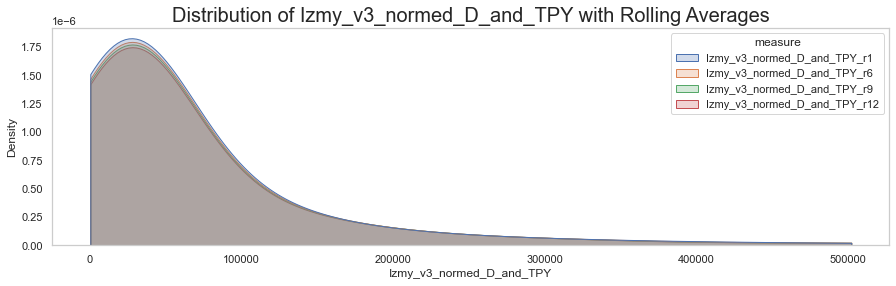

In [54]:
# Roll and print next instrument

col_index += 1

col_to_roll = cols_to_roll[col_index]
rolling_periods = [1, 6, 9, 12]
new_cols = []

for period in rolling_periods:
    df = create_rolling_avg(df, var_name=col_to_roll, num_months=period)
    new_cols.append(col_to_roll + "_r" + str(period))
    
all_cols.append([col_to_roll] + new_cols)
    
show_cols = base_cols + new_cols

# show df
# df[show_cols].head(20)

# count of nulls after adding rolling IVs
# df.isna().sum()[df.isna().sum() > 0]

title_str = 'Distribution of ' + col_to_roll + ' with Rolling Averages'
name_str = col_to_roll
low_end = df[new_cols].min().min()
high_end = df[new_cols].max().max()

clip_tuple_val=(low_end, high_end/100)

kde_multiple_plotter(col_list=new_cols, title_str=title_str, value_name_str=name_str, df_plot=df, clip_tuple=clip_tuple_val)

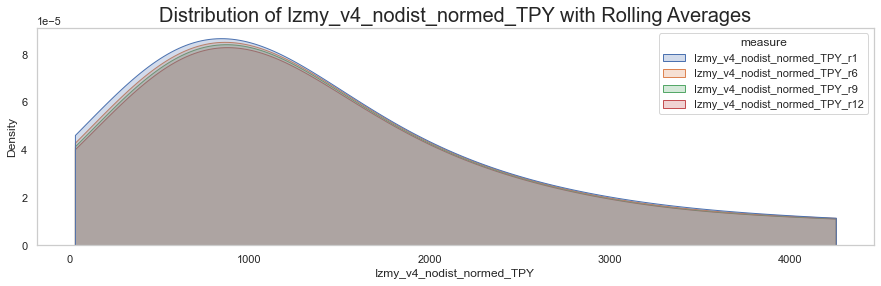

In [55]:
# Roll and print next instrument

col_index += 1

col_to_roll = cols_to_roll[col_index]
rolling_periods = [1, 6, 9, 12]
new_cols = []

for period in rolling_periods:
    df = create_rolling_avg(df, var_name=col_to_roll, num_months=period)
    new_cols.append(col_to_roll + "_r" + str(period))
    
all_cols.append([col_to_roll] + new_cols)

show_cols = base_cols + new_cols

# show df
# df[show_cols].head(20)

# count of nulls after adding rolling IVs
# df.isna().sum()[df.isna().sum() > 0]

title_str = 'Distribution of ' + col_to_roll + ' with Rolling Averages'
name_str = col_to_roll
low_end = df[new_cols].min().min()
high_end = df[new_cols].max().max()

clip_tuple_val=(low_end, high_end/100)

kde_multiple_plotter(col_list=new_cols, title_str=title_str, value_name_str=name_str, df_plot=df, clip_tuple=clip_tuple_val)

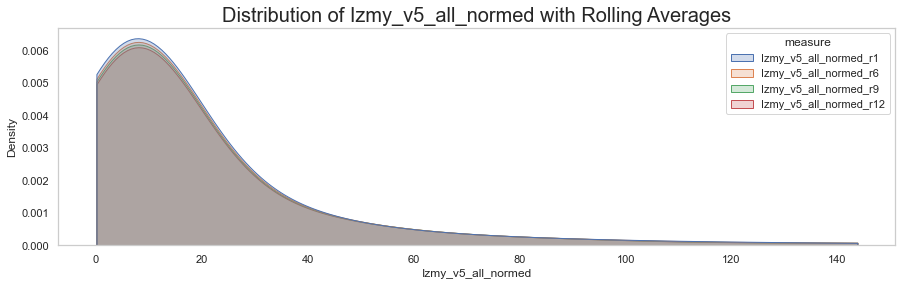

In [56]:
# Roll and print next instrument

col_index += 1

col_to_roll = cols_to_roll[col_index]
rolling_periods = [1, 6, 9, 12]
new_cols = []

for period in rolling_periods:
    df = create_rolling_avg(df, var_name=col_to_roll, num_months=period)
    new_cols.append(col_to_roll + "_r" + str(period))
    
all_cols.append([col_to_roll] + new_cols)

show_cols = base_cols + new_cols

# show df
# df[show_cols].head(20)

# count of nulls after adding rolling IVs
# df.isna().sum()[df.isna().sum() > 0]

title_str = 'Distribution of ' + col_to_roll + ' with Rolling Averages'
name_str = col_to_roll
low_end = df[new_cols].min().min()
high_end = df[new_cols].max().max()

clip_tuple_val=(low_end, high_end/100)

kde_multiple_plotter(col_list=new_cols, title_str=title_str, value_name_str=name_str, df_plot=df, clip_tuple=clip_tuple_val)

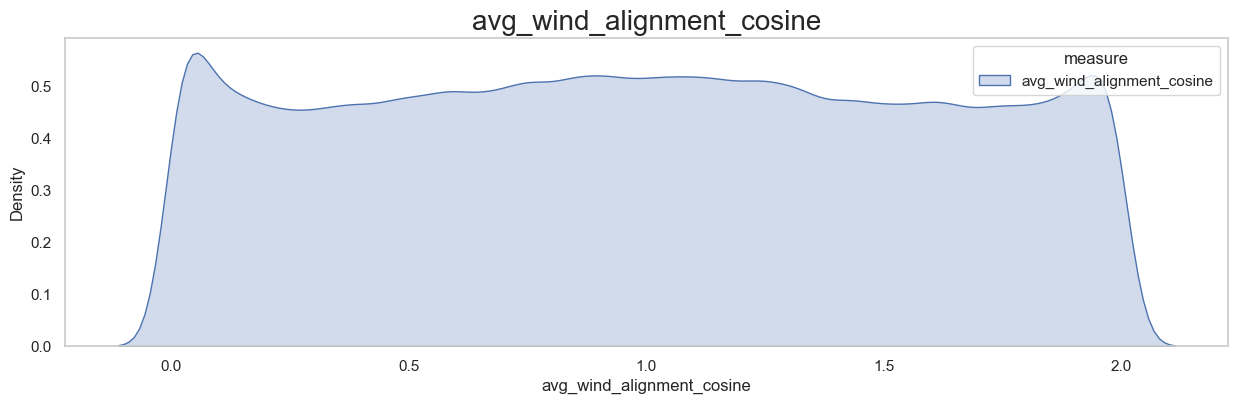

In [18]:
kde_multiple_plotter(col_list = ['avg_wind_alignment_cosine'], title_str = 'avg_wind_alignment_cosine', value_name_str = 'avg_wind_alignment_cosine', df_plot=df)

Convert `avg_wind_alignment` angle to `cos(x) + 1` to make `avg_wind_alignment_cosine`

In [19]:
def cos_convert_multiple(row):
    def calc_cos(n):
        return round(np.cos(np.radians(n)) + 1, 6)

    return [calc_cos(row['avg_wind_alignment_r1']), calc_cos(row['avg_wind_alignment_r6']), calc_cos(row['avg_wind_alignment_r9']), calc_cos(row['avg_wind_alignment_r12'])]

In [20]:
temp = df.apply(cos_convert_multiple, axis=1, result_type='expand')

temp.head(20)

,0,1,2,3
0,NaN,NaN,NaN,NaN
1322,1.129458,NaN,NaN,NaN
2644,0.492592,NaN,NaN,NaN
3966,0.157847,NaN,NaN,NaN
5288,0.090815,NaN,NaN,NaN
6611,0.090529,NaN,NaN,NaN
7934,0.392119,0.338071,NaN,NaN
9258,0.245753,0.224539,NaN,NaN
10582,0.310860,0.201099,NaN,NaN
11906,0.388841,0.236849,0.329605,NaN


In [21]:
temp.columns
d = {
    0: 'avg_wind_alignment_cosine_r1',
    1: 'avg_wind_alignment_cosine_r6',
    2: 'avg_wind_alignment_cosine_r9',
    3: 'avg_wind_alignment_cosine_r12'
}
temp.rename(columns=d, inplace=True)
temp.head(13)

,avg_wind_alignment_cosine_r1,avg_wind_alignment_cosine_r6,avg_wind_alignment_cosine_r9,avg_wind_alignment_cosine_r12
0,NaN,NaN,NaN,NaN
1322,1.129458,NaN,NaN,NaN
2644,0.492592,NaN,NaN,NaN
3966,0.157847,NaN,NaN,NaN
5288,0.090815,NaN,NaN,NaN
6611,0.090529,NaN,NaN,NaN
7934,0.392119,0.338071,NaN,NaN
9258,0.245753,0.224539,NaN,NaN
10582,0.310860,0.201099,NaN,NaN
11906,0.388841,0.236849,0.329605,NaN


In [22]:
df[temp.columns] = temp

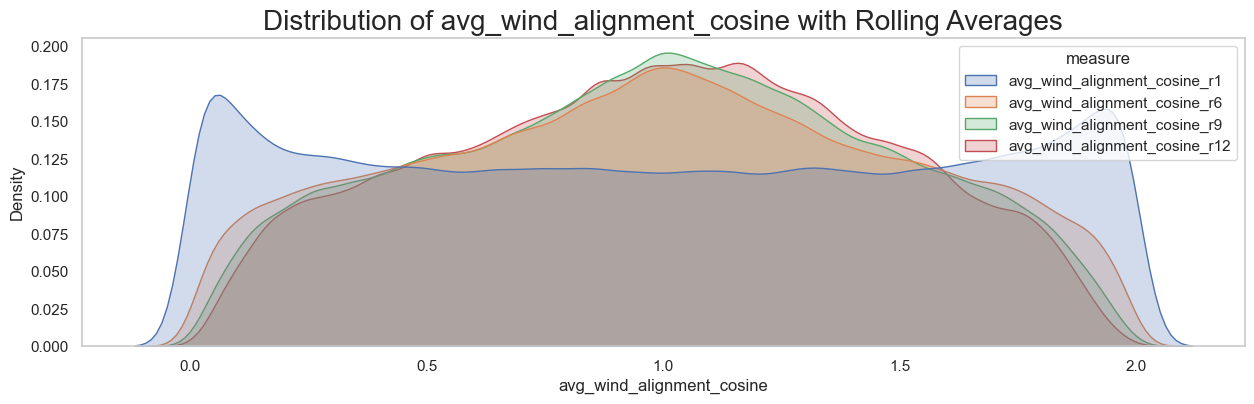

In [23]:
rolling_avg_wind_alignment_cosine_cols = ['avg_wind_alignment_cosine_r1', 'avg_wind_alignment_cosine_r6', 'avg_wind_alignment_cosine_r9', 'avg_wind_alignment_cosine_r12']
title_str = 'Distribution of avg_wind_alignment_cosine with Rolling Averages'
name_str = 'avg_wind_alignment_cosine'
clip_tuple_val=(-5, 185)

kde_multiple_plotter(col_list = rolling_avg_wind_alignment_cosine_cols, title_str = title_str, value_name_str = name_str, df_plot=df, clip_tuple=None)

In [57]:
# our new input variables

# set this for which instrument number you want to use
which_instrument = 1

stage_1_targets = ['pm25', 'pm25_last_month', 'pm25_r6', 'pm25_r9', 'pm25_r12']

stage_1_predictor_angles = all_cols[which_instrument - 1]

stage1_io_df = pd.DataFrame()

stage1_io_df['stage_1_targets'] = stage_1_targets
stage1_io_df['stage_1_predictor_angles'] = stage_1_predictor_angles

print("This is a mapping of targets and instrumental variable predictors we can use for stage 1:\n")

display(stage1_io_df)

This is a mapping of targets and instrumental variable predictors we can use for stage 1:



,stage_1_targets,stage_1_predictor_angles
0,pm25,Izmy_v1_unnormed
1,pm25_last_month,Izmy_v1_unnormed_r1
2,pm25_r6,Izmy_v1_unnormed_r6
3,pm25_r9,Izmy_v1_unnormed_r9
4,pm25_r12,Izmy_v1_unnormed_r12


In [25]:
# count of nulls after adding rolling IVs cosine'd
df.isna().sum()[df.isna().sum() > 0]

pm25_last_month                   1387
pm25_r6                           8322
pm25_r9                          12483
pm25_r12                         16644
pm25_r24                         33288
pm25_slope6                       8322
pm25_slope9                      12483
pm25_slope12                     16644
pm25_slope24                     33288
pm25_lag_12mo                    16644
avg_wind_alignment_r1             1387
avg_wind_alignment_r6             8322
avg_wind_alignment_r9            12483
avg_wind_alignment_r12           16644
avg_wind_alignment_cosine_r1      1387
avg_wind_alignment_cosine_r6      8322
avg_wind_alignment_cosine_r9     12483
avg_wind_alignment_cosine_r12    16644
dtype: int64

Clean the medical data

In [60]:
# med data:

# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + \
  df2['patzip_year_month'].to_list() + \
  df3['patzip_year_month'].to_list() + \
  df4['patzip_year_month'].to_list() + \
  df5['patzip_year_month'].to_list() 
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})
df4 = df4.rename(columns={'number_of_visits': 'number_of_visits_resp_cardio'})
df5 = df5.rename(columns={'number_of_visits': 'number_of_visits_injuries'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')\
  .merge(df4, on='patzip_year_month', how='left')\
  .merge(df5, on='patzip_year_month', how='left')

# join data
if isinstance(df.year_month[0], str):
  # if year month is still a string, convert it to datetime
  # don't try if already converted
  df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 
  'pediatric_vasculitis', 'number_of_visits_vasc', 
  'type_1_diabetes', 'number_of_visits_diab',
  'resp_cardio', 'number_of_visits_resp_cardio',
  'injuries_accidents', 'number_of_visits_injuries'
  ]
for var in med_vars:
  df[var] = df[var].fillna(0)

# fixing month datatype
df['month'] = df['month'].astype(str)

# Create response variables, which is visits / population
df['y_hematopoietic'] = 1000 * df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = 1000 * df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = 1000 * df['number_of_visits_diab'] / df['total_pop_under19']
df['y_resp_cardio'] = 1000 * df['number_of_visits_resp_cardio'] / df['total_pop_under19']
df['y_injuries'] = 1000 * df['number_of_visits_injuries'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])
df['pm25_last_month_log'] = np.log1p(df['pm25_last_month'])
df['pm25_r6_log'] = np.log1p(df['pm25_r6'])
df['pm25_r9_log'] = np.log1p(df['pm25_r9'])
df['pm25_r12_log'] = np.log1p(df['pm25_r12'])


# create year trend feature
df['year_trend'] = df['year'] - 1999

# create county_month
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# create year_month_county (in case we want to just direclty use this var for the interaction effects)
df['year_month_county'] = df.apply(lambda df: str(df['year']) + '_' + df['month'] + '_' + df['school_county_v2'], axis=1)

Generate lag windows for our outcomes.

Lag window includes the current month we are inspecting. These will be used to form our health outcomes for stage 2.

As of this notebook, for our windows are for:

```
med_vars = ['number_of_visits_hem_cancers', 
  'number_of_visits_vasc', 
  'number_of_visits_diab',
  'number_of_visits_resp_cardio',
  'number_of_visits_injuries'
  ]
```

For each of the health outcomes, produce columns for the following lag windows:

- 3 months
- 6 months
- 12 months

This is using the current month as the starting month

In [61]:
# make sure the df is sorted
df = df.sort_values(['school_zip', 'year_month'])

df.head(5)

,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,avg_wspd_top_5,avg_u,avg_v,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools,zip_year_month,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab,resp_cardio,number_of_visits_resp_cardio,injuries_accidents,number_of_visits_injuries,y_hematopoietic,y_vasculitis,y_diabetes,y_resp_cardio,y_injuries,pm25_log,pm25_last_month_log,pm25_r6_log,pm25_r9_log,pm25_r12_log,year_trend,county_month,year_month_county
0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,0.757031,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90001-2000-1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.501043,NaN,NaN,NaN,NaN,1,01_Los Angeles,2000_1_Los Angeles
1322,2000-02-01,90001,Los Angeles,Los Angeles Count

In [63]:
# get rolling n month avg

def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df`: returns dataframe with column added
  """

  # df_temp = df[['year_month', 'school_zip', var_name]].copy(deep=True)
  
  ### Doesn't work
  # df[f'{var_name}_fwd{num_months}'] = df_temp.set_index('year_month')\
  #                                     .groupby(['school_zip'])[var_name]\
  #                                     .apply(lambda x: x.asfreq('1MS').rolling(num_months).sum().shift(1-num_months))\
  #                                       .reset_index()[var_name]

  if center_arg:
    df[f'{var_name}_cent{num_months}'] = df.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df[f'{var_name}_fwd{num_months}'] = df.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  ### Doesn't work
  # df = pd.merge(df, df_temp.set_index('year_month')\
  #   .groupby(['school_zip'])[var_name]\
  #       .apply(lambda x: x.asfreq('1M').rolling(num_months).sum().shift(1-num_months)).reset_index(),\
  #           on=['year_month', 'school_zip']).rename(columns={'{var_name}_x': '{var_name}', '{var_name}_y': '{var_name}_fwd{num_months}'})  
  
  return df 

Filter out the dataset rows so last year_month is Dec 2017.

We do not want to fill health outcomes with unreliable data, and health data only goes up to 2017. 

In [64]:
print(f"Minimum date in dataset: {min(df['year_month'])} ")
print(f"Minimum date in dataset: {max(df['year_month'])} ")

print(f"Number of rows in dataset: {df.shape[0]}")

# Filter out dataset's rows to end on Dec 2017
print('\n--- Filter out dataset rows to end on Dec 2017 ---\n')

df_2 = df[df['year_month'] < '2018-01-01']

print(f"Minimum date in dataset: {min(df_2['year_month'])} ")
print(f"Minimum date in dataset: {max(df_2['year_month'])} ")

print(f"Number of rows in dataset: {df_2.shape[0]}")

Minimum date in dataset: 2001-01-01 00:00:00 
Minimum date in dataset: 2017-12-01 00:00:00 
Number of rows in dataset: 279016

--- Filter out dataset rows to end on Dec 2017 ---

Minimum date in dataset: 2001-01-01 00:00:00 
Minimum date in dataset: 2017-12-01 00:00:00 
Number of rows in dataset: 279016


**Make the rolling health outcomes.**

Naming format for y variables goes:

`y_{condition name}_{cent if centered on current, fwd if looking forward from current}{number of months}`

Examples:
- `'y_hematopoietic_fwd3'`
- `'y_hematopoietic_cent3'`

Original name:
- `'y_hematopoietic'`

In [65]:
# make rolling sum columns

df_2 = df_2.sort_values(['school_zip', 'year_month'])
starting_cols = list(df_2.columns)

num_visits_col_names = ['number_of_visits_hem_cancers', 
  'number_of_visits_vasc', 
  'number_of_visits_diab',
  'number_of_visits_resp_cardio',
  'number_of_visits_injuries'
  ]

y_col_names = ['y_hematopoietic', 
  'y_vasculitis', 
  'y_diabetes',
  'y_resp_cardio',
  'y_injuries'
  ]


# 3 months ---
n = 3 # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_2[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_fwd{n}'] / df_2['total_pop_under19']

    # centered columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_2[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_cent{n}'] / df_2['total_pop_under19']


# print columns added
ending_cols = list(df_2.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 3 month window:\n{window_3months_columns}")
starting_cols = list(df_2.columns)


# 6 months ---
n = 6

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_2[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_fwd{n}'] / df_2['total_pop_under19']

    # centered columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_2[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_cent{n}'] / df_2['total_pop_under19']


# print columns added
ending_cols = list(df_2.columns)
window_6months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 6 month window:\n{window_6months_columns}")
starting_cols = list(df_2.columns)


# 12 months ---
n = 12

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_2[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_fwd{n}'] / df_2['total_pop_under19']

    # centered columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_2[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_cent{n}'] / df_2['total_pop_under19']


ending_cols = list(df_2.columns)
window_12months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 12 month window:\n{window_12months_columns}")
starting_cols = list(df_2.columns)


Columns added for health outcomes using 3 month window:
['number_of_visits_hem_cancers_fwd3', 'y_hematopoietic_fwd3', 'number_of_visits_hem_cancers_cent3', 'y_hematopoietic_cent3', 'number_of_visits_vasc_fwd3', 'y_vasculitis_fwd3', 'number_of_visits_vasc_cent3', 'y_vasculitis_cent3', 'number_of_visits_diab_fwd3', 'y_diabetes_fwd3', 'number_of_visits_diab_cent3', 'y_diabetes_cent3', 'number_of_visits_resp_cardio_fwd3', 'y_resp_cardio_fwd3', 'number_of_visits_resp_cardio_cent3', 'y_resp_cardio_cent3', 'number_of_visits_injuries_fwd3', 'y_injuries_fwd3', 'number_of_visits_injuries_cent3', 'y_injuries_cent3']

Columns added for health outcomes using 6 month window:
['number_of_visits_hem_cancers_fwd6', 'y_hematopoietic_fwd6', 'number_of_visits_hem_cancers_cent6', 'y_hematopoietic_cent6', 'number_of_visits_vasc_fwd6', 'y_vasculitis_fwd6', 'number_of_visits_vasc_cent6', 'y_vasculitis_cent6', 'number_of_visits_diab_fwd6', 'y_diabetes_fwd6', 'number_of_visits_diab_cent6', 'y_diabetes_cent6', 

In [66]:
# example checking that it is working
df_2[df_2.school_zip == 91331][['year_month', 'school_zip', 'number_of_visits_resp_cardio_fwd3', 'y_resp_cardio_fwd3', 'number_of_visits_resp_cardio_cent3', 'y_resp_cardio_cent3']].tail(12)

,year_month,school_zip,number_of_visits_resp_cardio_fwd3,y_resp_cardio_fwd3,number_of_visits_resp_cardio_cent3,y_resp_cardio_cent3
278761,2017-01-01,91331,1764.0,58.733435,1801.0,59.965373
280123,2017-02-01,91331,1674.0,55.736832,1764.0,58.733435
281485,2017-03-01,91331,1513.0,50.376240,1674.0,55.736832
282847,2017-04-01,91331,1282.0,42.684957,1513.0,50.376240
284209,2017-05-01,91331,1071.0,35.659586,1282.0,42.684957
285571,2017-06-01,91331,925.0,30.798428,1071.0,35.659586
286932,2017-07-01,91331,1029.0,34.261171,925.0,30.798428
288290,2017-08-01,91331,757.0,25.204768,1029.0,34.261171
289648,2017-09-01,91331,889.0,29.599787,757.0,25.204768
291006,2017-10-01,91331,970.0,32.296730,889.0,29.599787


Make plots to see how rolling lagged health outcomes shift the distribution. 

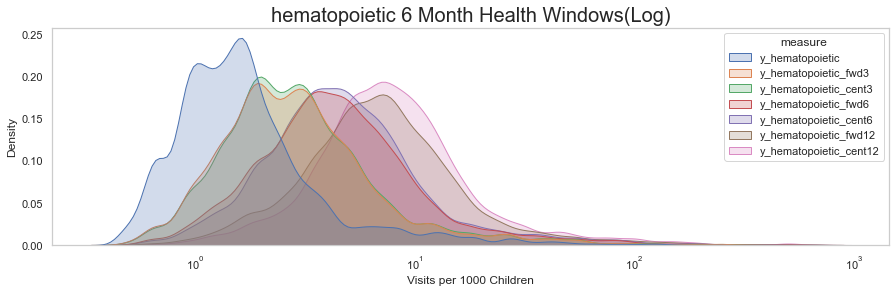

In [68]:
temp_list = ['y_hematopoietic','y_hematopoietic_fwd3', 'y_hematopoietic_cent3', 'y_hematopoietic_fwd6', 'y_hematopoietic_cent6', 'y_hematopoietic_fwd12', 'y_hematopoietic_cent12']
kde_multiple_plotter(col_list=temp_list, title_str='hematopoietic 6 Month Health Windows', value_name_str='Visits per 1000 Children', df_plot=df_2[df_2.y_hematopoietic > 0], log_scale_value=True)

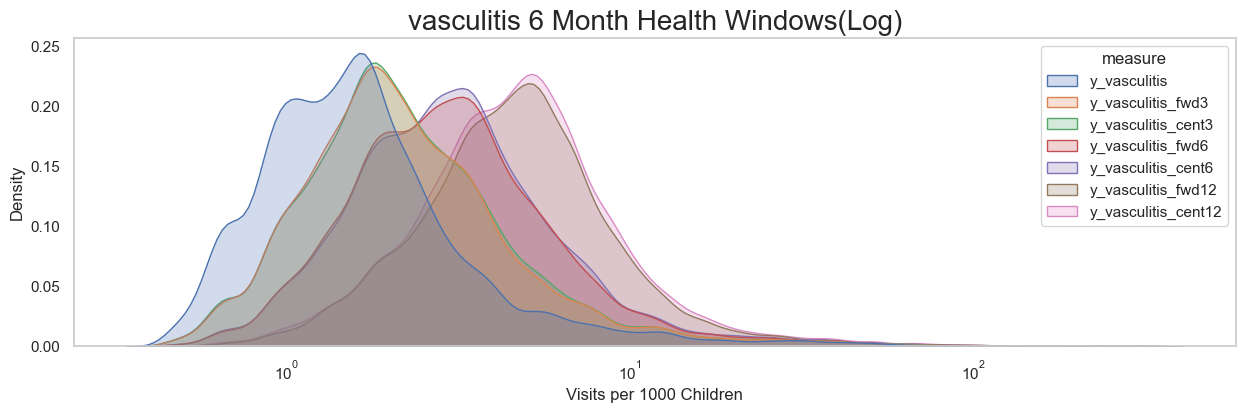

In [33]:
temp_list = ['y_vasculitis','y_vasculitis_fwd3', 'y_vasculitis_cent3', 'y_vasculitis_fwd6', 'y_vasculitis_cent6', 'y_vasculitis_fwd12', 'y_vasculitis_cent12']
kde_multiple_plotter(col_list=temp_list, title_str='vasculitis 6 Month Health Windows', value_name_str='Visits per 1000 Children', df_plot=df_2[df_2.y_vasculitis > 0], log_scale_value=True)

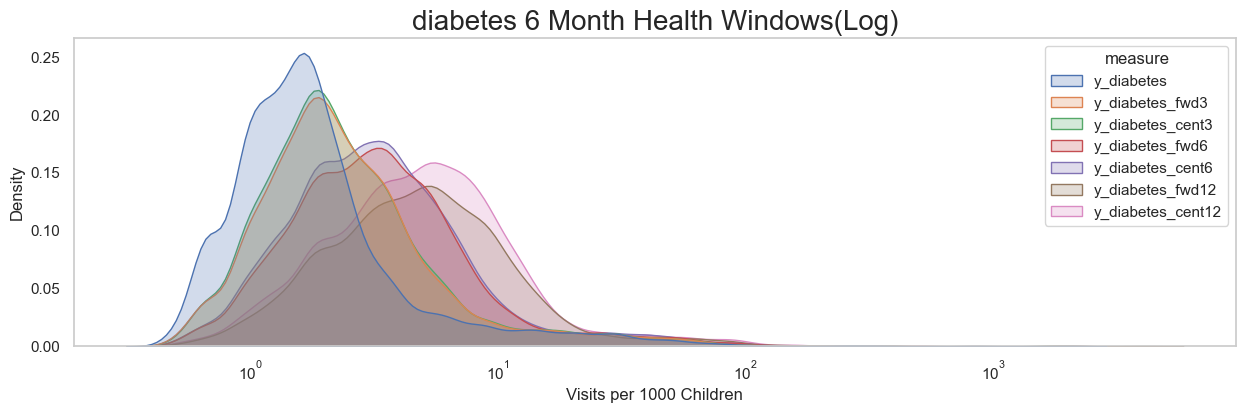

In [34]:
temp_list = ['y_diabetes','y_diabetes_fwd3', 'y_diabetes_cent3', 'y_diabetes_fwd6', 'y_diabetes_cent6', 'y_diabetes_fwd12', 'y_diabetes_cent12']
kde_multiple_plotter(col_list=temp_list, title_str='diabetes 6 Month Health Windows', value_name_str='Visits per 1000 Children', df_plot=df_2[df_2.y_diabetes > 0], log_scale_value=True)

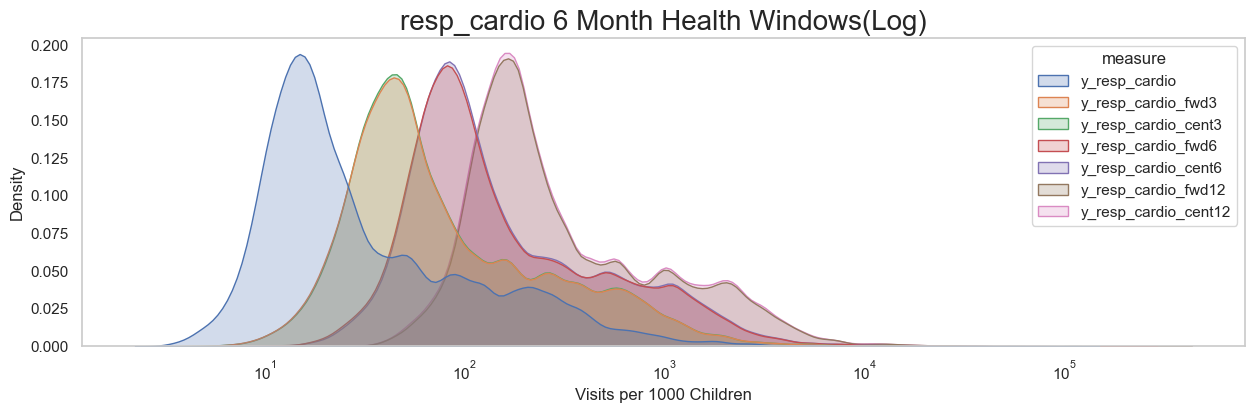

In [35]:
temp_list = ['y_resp_cardio','y_resp_cardio_fwd3', 'y_resp_cardio_cent3', 'y_resp_cardio_fwd6', 'y_resp_cardio_cent6', 'y_resp_cardio_fwd12', 'y_resp_cardio_cent12']
kde_multiple_plotter(col_list=temp_list, title_str='resp_cardio 6 Month Health Windows', value_name_str='Visits per 1000 Children', df_plot=df_2[df_2.y_resp_cardio > 0], log_scale_value=True)

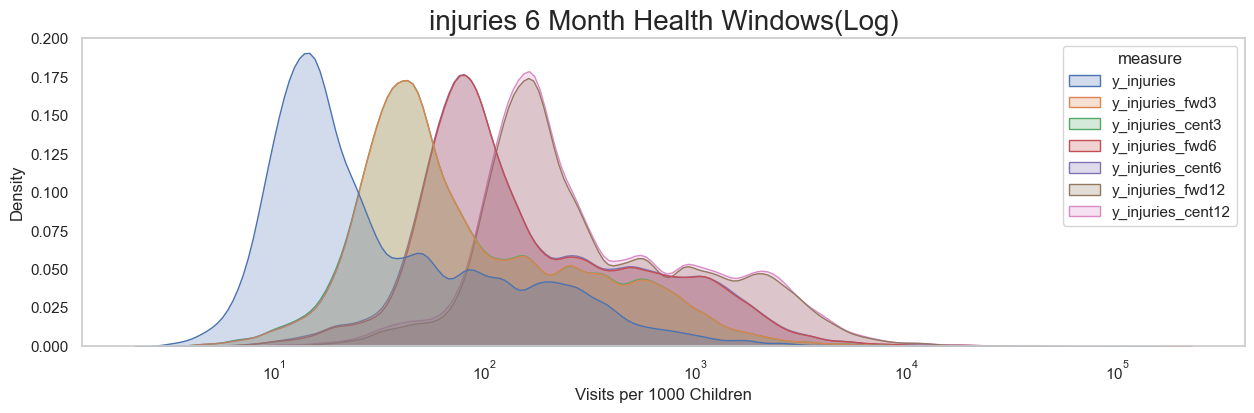

In [36]:
temp_list = ['y_injuries','y_injuries_fwd3', 'y_injuries_cent3', 'y_injuries_fwd6', 'y_injuries_cent6', 'y_injuries_fwd12', 'y_injuries_cent12']
kde_multiple_plotter(col_list=temp_list, title_str='injuries 6 Month Health Windows', value_name_str='Visits per 1000 Children', df_plot=df_2[df_2.y_injuries > 0], log_scale_value=True)

Filter out rows before 2002, because the pollution source data Michelle has is unrealiable from 2000 - 2002

To avoid having poor quality data with noise, we can filter out rows with `year_month` before '2002-01-01'.

This will still leave us with nulls in the rolling features columns. Filter out those nulls as needed prior to modeling.

In [69]:
print(f"Minimum date in dataset: {min(df_2['year_month'])} ")
print(f"Minimum date in dataset: {max(df_2['year_month'])} ")

print(f"Number of rows in dataset: {df_2.shape[0]}")

print(f"\n---Filtering out data before 2002---\n")
df_3 = df_2[df_2['year_month'] > '2001-12-31']

print(f"Minimum date in dataset: {min(df_3['year_month'])} ")
print(f"Minimum date in dataset: {max(df_3['year_month'])} ")

print(f"Number of rows in dataset: {df_3.shape[0]}")

Minimum date in dataset: 2001-01-01 00:00:00 
Minimum date in dataset: 2017-12-01 00:00:00 
Number of rows in dataset: 279016

---Filtering out data before 2002---

Minimum date in dataset: 2002-01-01 00:00:00 
Minimum date in dataset: 2017-12-01 00:00:00 
Number of rows in dataset: 262674


Check for Nulls in our columns

In [70]:
df_3.isna().sum()[df_3.isna().sum() > 0]

pm25_last_month                            24
pm25_r6                                   146
pm25_r9                                   224
pm25_r12                                  302
pm25_r24                                 1065
pm25_slope6                               146
pm25_slope9                               224
pm25_slope12                              302
pm25_slope24                             1065
pm25_lag_12mo                             302
patzip_year_month                      153130
pm25_last_month_log                        24
pm25_r6_log                               146
pm25_r9_log                               224
pm25_r12_log                              302
number_of_visits_hem_cancers_fwd3        2774
y_hematopoietic_fwd3                     2774
number_of_visits_hem_cancers_cent3       1411
y_hematopoietic_cent3                    1411
number_of_visits_vasc_fwd3               2774
y_vasculitis_fwd3                        2774
number_of_visits_vasc_cent3       

Check the low population areas for our columns.

If these are the same, no need to change anything.

In [71]:
print(df_3.shape[0])
print(df_3[df_3['total_pop_under19'] >= 1].shape[0])

262674
262674


Consider dropping low count populations

In [40]:
# print(df.shape[0])
# df = df[df['total_pop_under19'] >= 100]
# print(df.shape[0])

Function to get condensed model output

In [72]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

#get_ols_res(fit1).head(1)

# First stage regression - Predict pm2.5 levels

- QQplot says the residuals are skewed right and have heavy tails (same with logged version, but less skewed).

Get data into right model form. Listing the various fixed effects combinations we've tried. 

In [9]:
# original set up
# y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + school_county_v2 + month + year_trend * C(county_month)', 
#   data=df, return_type='dataframe')


# anands set up
# y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + school_county_v2 + month + year_trend * C(county_month) + \
#   total_pop_under19 + total_population + dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
#   school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature', 
#   data=df, return_type='dataframe')


# dropping population ones to avoid data leakage
# y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + \
#   dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
#   school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature + \
#   school_county_v2 + month + year_trend * C(county_month)', 
#   data=df, return_type='dataframe')

**Filter out rows where nulls exist on the predictor and target.**

Based on which windows you use for prediction's IV, the pm2.5 target, and health outcome target, filter out the rows with nulls in them now before forming the X matrix.

In [73]:
display(df_3)

IV lead input (months): r9
HO lag input (months): fwd3



pm25_r12                                   78
pm25_r24                                  841
pm25_slope12                               78
pm25_slope24                              841
pm25_lag_12mo                              78
avg_wind_alignment_r12                     78
avg_wind_alignment_cosine_r12              78
patzip_year_month                      151592
pm25_r12_log                               78
number_of_visits_hem_cancers_fwd6        4161
y_hematopoietic_fwd6                     4161
number_of_visits_vasc_fwd6               4161
y_vasculitis_fwd6                        4161
number_of_visits_diab_fwd6               4161
y_diabetes_fwd6                          4161
number_of_visits_resp_cardio_fwd6        4161
y_resp_cardio_fwd6                       4161
number_of_visits_injuries_fwd6           4161
y_injuries_fwd6                          4161
number_of_visits_hem_cancers_fwd12      12483
y_hematopoietic_fwd12                   12483
number_of_visits_hem_cancers_cent1

In [44]:
df_model.shape[0]

259676

In [45]:
if clean_memory:
    del df2
    del df

# 1st Stage Regression (New)

## Specify which predictor to use here:

In [75]:
# cols_to_roll = ['Izmy_v1_unnormed',
# 'Izmy_v2_nodist_unnormed',
# 'Izmy_v3_normed_D_and_TPY',
# 'Izmy_v4_nodist_normed_TPY',
# 'Izmy_v5_all_normed']

lead_predictor = 'Izmy_v1_unnormed'
lead_time = 9
lag_style = 'fwd'
lag_time = 3

In [76]:
# filter out df_3 based on our windows for IV and health outcome:
df_model = df_3

# define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
IV_lead = "r" + str(lead_time)
HO_lag = lag_style + str(lag_time)

if IV_lead:
    IV_lead_input = "_" + IV_lead 
else:
    # don't add underscore if empty string
    IV_lead_input = IV_lead

# define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
if HO_lag:
    HO_lag_input = "_" + HO_lag 
else:
    # don't add underscore if empty string
    HO_lag_input = HO_lag

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")

# IV options: 1 month, 6 months, 9 months, 12 months
IV_window_col = [f'pm25{IV_lead_input}']

# health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
health_outcome_window_col = [f'y_injuries{HO_lag_input}']

filter_cols = IV_window_col + health_outcome_window_col

df_model = df_model.dropna(subset=filter_cols)

df_model.isna().sum()[df_model.isna().sum() > 0]

print(f"IV lead: {IV_lead}\n")

# dropping population ones to avoid data leakage
target_name_s1 = f'pm25{IV_lead_input}'
# predictor_name_s1 = f'avg_wind_alignment_cosine{IV_lead_input}'
predictor_name_s1 = f'{lead_predictor}{IV_lead_input}'


y, X = dmatrices(f'{target_name_s1} ~ {predictor_name_s1} + \
  dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
  school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature + \
  school_county_v2 + month + year_trend * C(county_month)', 
  data=df_model, return_type='dataframe')

# rearrange columns
X = X[[predictor_name_s1] + [i for i in X.columns if not re.search(predictor_name_s1, i)]]

# fit model
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df_model['yhat_pm25'] = fit1.fittedvalues.values

# save model
if save_results:
  fit1.save(os.path.join(fitted_models_path, 'stage1_ols.pickle'), remove_data=True)

# Get residuals
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

# calculate r^2
ss_resid = sum((df_model['yhat_pm25'].values - df_model[target_name_s1].values)**2)
ss_total = sum((df_model[target_name_s1].mean() - df_model[target_name_s1].values)**2)
r_squared = 1 - ss_resid / ss_total 
print('r squared: {:.4f}'.format(r_squared))

get_ols_res(fit1).head(3)

<AxesSubplot: >

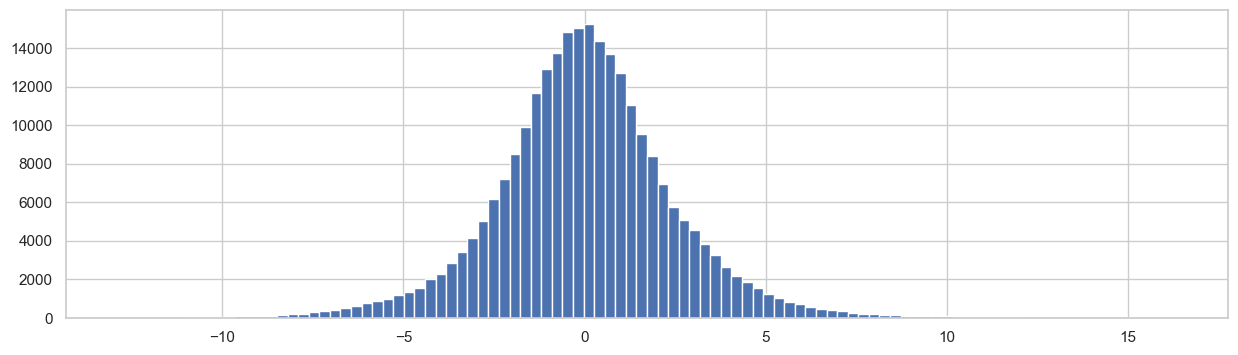

In [47]:
# histogram of the residuals
resids_and_fitted['resids'].hist(bins=100)

# Second Stage Regression (New)

- Stage 1 of the least squares regression: $\widehat{PM}_{2.5}=\beta_0 + \beta_1 \theta_{downstream} + \beta_{2}year + \beta_{3}month + \beta_{4}county + \epsilon$
  - $\theta_{downstream}$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 

- Stage 2 of the equation: $Y=\frac{\sum diagnoses}{Pop_{zipcode, 0-19}}=\delta_0 + \delta_1 \widehat{PM}_{2.5} + \delta_{2}year + \delta_{3}month + \delta_{4}county + \epsilon$


In addition to this two stage framework, also run the stage 2 regression using true pm2.5 values. So we can see how biased the coefficient is. 

In [48]:
# drop instrument, and add x_hat to the X matrix
X = X.drop(columns=predictor_name_s1)
X['yhat_pm25'] = df_model['yhat_pm25']
X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]] # put our pred pm25 in front
X_truepm25 = pd.concat([df_model[target_name_s1], X.drop(columns='yhat_pm25')], axis = 1)

In [49]:
target_name_s2_hema = f'y_hematopoietic{HO_lag_input}'

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")


# fit model
fit2_hema = sm.OLS(df_model[target_name_s2_hema], X).fit()

# save model
if save_results:
  fit2_hema.save(os.path.join(fitted_models_path, 'stage2_ols_hematopoietic.pickle'), remove_data=True)

# add fitted y value to our dataset
df_model['yhat_hematopoietic'] = fit2_hema.fittedvalues.values

# Get residuals
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_hema).head(1))

# fit model with true pm2.5
fit2_hema_truepm25 = sm.OLS(df_model[target_name_s2_hema], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_hema_truepm25).head(1))

IV lead input (months): r9
HO lag input (months): fwd3

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  0.287669  0.152139    -0.106057     0.681395

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0  pm25_r9  0.001521  0.691962    -0.006005     0.009048


In [50]:
target_name_s2_vasc = f'y_vasculitis{HO_lag_input}'

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")

# fit model
fit2_vasc = sm.OLS(df_model[target_name_s2_vasc], X).fit()

# save model
if save_results:
  fit2_vasc.save(os.path.join(fitted_models_path, 'stage2_ols_vasculitis.pickle'), remove_data=True)

# add fitted y value to our dataset
df_model['yhat_vasculitis'] = fit2_vasc.fittedvalues.values

# Get residuals
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_vasc).head(1))

# fit model with true pm2.5
fit2_vasc_truepm25 = sm.OLS(df_model[target_name_s2_vasc], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_vasc_truepm25).head(1))

IV lead input (months): r9
HO lag input (months): fwd3

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.429025  0.000207    -0.655641    -0.202409

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0  pm25_r9 -0.004732  0.032287    -0.009064      -0.0004


In [51]:
target_name_s2_diab = f'y_diabetes{HO_lag_input}'

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")

# fit model
fit2_diab = sm.OLS(df_model[target_name_s2_diab], X).fit()

# save model
if save_results:
  fit2_diab.save(os.path.join(fitted_models_path, 'stage2_ols_diabetes.pickle'), remove_data=True)

# add fitted y value to our dataset
df_model['yhat_diabetes'] = fit2_diab.fittedvalues.values

# Get residuals
resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_diab).head(1))

# fit model with true pm2.5
fit2_diab_truepm25 = sm.OLS(df_model[target_name_s2_diab], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_diab_truepm25).head(1))

IV lead input (months): r9
HO lag input (months): fwd3

yhat pm2.5:
    variable      coef  p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.929258  0.05592    -1.881996     0.023481

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0  pm25_r9 -0.001786  0.847603    -0.019999     0.016427


In [52]:
target_name_s2_resp_cardio = f'y_resp_cardio{HO_lag_input}'

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")


# fit model
fit2_resp_cardio = sm.OLS(df_model[target_name_s2_resp_cardio], X).fit()

# save model
if save_results:
  fit2_resp_cardio.save(os.path.join(fitted_models_path, 'stage2_ols_resp_cardio.pickle'), remove_data=True)

# add fitted y value to our dataset
df_model['yhat_resp_cardio'] = fit2_resp_cardio.fittedvalues.values

# Get residuals
resids_and_fitted_resp_cardio = pd.DataFrame({'resids': fit2_resp_cardio.resid, 'fitted': fit2_resp_cardio.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_resp_cardio).head(1))

# fit model with true pm2.5
fit2_resp_cardio_truepm25 = sm.OLS(df_model[target_name_s2_resp_cardio], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_resp_cardio_truepm25).head(1))

IV lead input (months): r9
HO lag input (months): fwd3

yhat pm2.5:
    variable       coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  131.12227  0.000644    55.811861   206.432678

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0  pm25_r9 -3.378135  0.000004    -4.817747    -1.938522


In [53]:
target_name_s2_injuries = f'y_injuries{HO_lag_input}'

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")


# fit model
fit2_injuries = sm.OLS(df_model[target_name_s2_injuries], X).fit()

# save model
if save_results:
  fit2_injuries.save(os.path.join(fitted_models_path, 'stage2_ols_injuries.pickle'), remove_data=True)

# add fitted y value to our dataset
df_model['yhat_injuries'] = fit2_injuries.fittedvalues.values

# Get residuals
resids_and_fitted_injuries = pd.DataFrame({'resids': fit2_injuries.resid, 'fitted': fit2_injuries.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_injuries).head(1))

# fit model with true pm2.5
fit2_injuries_truepm25 = sm.OLS(df_model[target_name_s2_injuries], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_injuries_truepm25).head(1))

IV lead input (months): r9
HO lag input (months): fwd3

yhat pm2.5:
    variable        coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  134.477844  0.000258     62.34659   206.609098

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0  pm25_r9 -2.588753  0.000234    -3.967619    -1.209887


## All results (new)

In [54]:
print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")


all_res_yhat = [get_ols_res(x).head(1) for x in [fit2_hema, fit2_vasc, fit2_diab, fit2_resp_cardio, fit2_injuries]]
all_res_true = [get_ols_res(x).head(1) for x in [fit2_hema_truepm25, fit2_vasc_truepm25, fit2_diab_truepm25, fit2_resp_cardio_truepm25, fit2_injuries_truepm25]]

all_res_yhat = pd.concat(all_res_yhat)
all_res_true = pd.concat(all_res_true)

print("Stage 1 results:")
print(get_ols_res(fit1).head(1))


print("\nStage 2 results:")
df_res = pd.DataFrame({
  'yvar': ['hematopoietic', 'vasculitis', 'diabetes', 'respiratory', 'injuries']
  
  ,'coef_pm25_yhat': all_res_yhat['coef'].values
  ,'pvalue_pm25_yhat': all_res_yhat['p_value'].values
  ,'ci95_lower_pm25_yhat': all_res_yhat['95_ci_lower'].values
  ,'ci95_upper_pm25_yhat': all_res_yhat['95_ci_upper'].values

  ,'coef_pm25_true': all_res_true['coef'].values
  ,'pvalue_pm25_true': all_res_true['p_value'].values
  ,'ci95_lower_pm25_true': all_res_true['95_ci_lower'].values
  ,'ci95_upper_pm25_true': all_res_true['95_ci_upper'].values
})
df_res

IV lead input (months): r9
HO lag input (months): fwd3

Stage 1 results:
                variable      coef       p_value  95_ci_lower  95_ci_upper
0  avg_wind_alignment_r9 -0.001627  2.581863e-22    -0.001956    -0.001299

Stage 2 results:


,yvar,coef_pm25_yhat,pvalue_pm25_yhat,ci95_lower_pm25_yhat,ci95_upper_pm25_yhat,coef_pm25_true,pvalue_pm25_true,ci95_lower_pm25_true,ci95_upper_pm25_true
0,hematopoietic,0.287669,0.152139,-0.106057,0.681395,0.001521,0.691962,-0.006005,0.009048
1,vasculitis,-0.429025,0.000207,-0.655641,-0.202409,-0.004732,0.032287,-0.009064,-0.000400
2,diabetes,-0.929258,0.055920,-1.881996,0.023481,-0.001786,0.847603,-0.019999,0.016427
3,respiratory,131.122270,0.000644,55.811861,206.432678,-3.378135,0.000004,-4.817747,-1.938522
4,injuries,134.477844,0.000258,62.346590,206.609098,-2.588753,0.000234,-3.967619,-1.209887


# Second Stage Regression

- Stage 1 of the least squares regression: $\widehat{PM}_{2.5}=\beta_0 + \beta_1 \theta_{downstream} + \beta_{2}year + \beta_{3}month + \beta_{4}county + \epsilon$
  - $\theta_{downstream}$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 

- Stage 2 of the equation: $Y=\frac{\sum diagnoses}{Pop_{zipcode, 0-19}}=\delta_0 + \delta_1 \widehat{PM}_{2.5} + \delta_{2}year + \delta_{3}month + \delta_{4}county + \epsilon$


In addition to this two stage framework, also run the stage 2 regression using true pm2.5 values. So we can see how biased the coefficient is. 

In [15]:
# drop instrument, and add x_hat to the X matrix
X = X.drop(columns='avg_wind_alignment_cosine')
X['yhat_pm25'] = df['yhat_pm25']
X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]] # put our pred pm25 in front
X_truepm25 = pd.concat([df['pm25'], X.drop(columns='yhat_pm25')], axis = 1)

In [16]:
# fit model
fit2_hema = sm.OLS(df['y_hematopoietic'], X).fit()

# save model
if save_results:
  fit2_hema.save(os.path.join(fitted_models_path, 'stage2_ols_hematopoietic.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_hematopoietic'] = fit2_hema.fittedvalues.values

# Get residuals
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_hema).head(1))

# fit model with true pm2.5
fit2_hema_truepm25 = sm.OLS(df['y_hematopoietic'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_hema_truepm25).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  0.100868  0.066402    -0.006828     0.208565

true pm2.5:
  variable      coef  p_value  95_ci_lower  95_ci_upper
0     pm25 -0.001279  0.17311    -0.003119     0.000561


In [17]:
# fit model
fit2_vasc = sm.OLS(df['y_vasculitis'], X).fit()

# save model
if save_results:
  fit2_vasc.save(os.path.join(fitted_models_path, 'stage2_ols_vasculitis.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_vasculitis'] = fit2_vasc.fittedvalues.values

# Get residuals
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_vasc).head(1))

# fit model with true pm2.5
fit2_vasc_truepm2 = sm.OLS(df['y_vasculitis'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_vasc_truepm2).head(1))

yhat pm2.5:
    variable      coef  p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.084259  0.01914    -0.154749    -0.013768

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.002089  0.000677    -0.003293    -0.000884


In [18]:
# fit model
fit2_diab = sm.OLS(df['y_diabetes'], X).fit()

# save model
if save_results:
  fit2_diab.save(os.path.join(fitted_models_path, 'stage2_ols_diabetes.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_diabetes'] = fit2_diab.fittedvalues.values

# Get residuals
resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_diab).head(1))

# fit model with true pm2.5
fit2_diab_truepm2 = sm.OLS(df['y_diabetes'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_diab_truepm2).head(1))

yhat pm2.5:
    variable    coef  p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.1118  0.44766     -0.40038      0.17678

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.006105  0.015245    -0.011036    -0.001174


In [19]:
# fit model
fit2_resp_cardio = sm.OLS(df['y_resp_cardio'], X).fit()

# save model
if save_results:
  fit2_resp_cardio.save(os.path.join(fitted_models_path, 'stage2_ols_resp_cardio.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_resp_cardio'] = fit2_resp_cardio.fittedvalues.values

# Get residuals
resids_and_fitted_resp_cardio = pd.DataFrame({'resids': fit2_resp_cardio.resid, 'fitted': fit2_resp_cardio.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_resp_cardio).head(1))

# fit model with true pm2.5
fit2_resp_cardio_truepm2 = sm.OLS(df['y_resp_cardio'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_resp_cardio_truepm2).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  4.352866  0.716178   -19.112949    27.818681

true pm2.5:
  variable     coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.81773  0.000064    -1.218691     -0.41677


In [20]:
# fit model
fit2_injuries = sm.OLS(df['y_injuries'], X).fit()

# save model
if save_results:
  fit2_injuries.save(os.path.join(fitted_models_path, 'stage2_ols_injuries.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_injuries'] = fit2_injuries.fittedvalues.values

# Get residuals
resids_and_fitted_injuries = pd.DataFrame({'resids': fit2_injuries.resid, 'fitted': fit2_injuries.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_injuries).head(1))

# fit model with true pm2.5
fit2_injuries_truepm2 = sm.OLS(df['y_injuries'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_injuries_truepm2).head(1))

yhat pm2.5:
    variable       coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  28.180641  0.015838     5.287337    51.073945

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.808092  0.000051    -1.199274     -0.41691


## All results

In [21]:
all_res_yhat = [get_ols_res(x).head(1) for x in [fit2_hema, fit2_vasc, fit2_diab, fit2_resp_cardio, fit2_injuries]]
all_res_true = [get_ols_res(x).head(1) for x in [fit2_hema_truepm25, fit2_vasc_truepm2, fit2_diab_truepm2, fit2_resp_cardio_truepm2, fit2_injuries_truepm2]]

all_res_yhat = pd.concat(all_res_yhat)
all_res_true = pd.concat(all_res_true)

print("Stage 1 results:")
print(get_ols_res(fit1).head(1))


print("\nStage 2 results:")
df_res = pd.DataFrame({
  'yvar': ['hematopoietic', 'vasculitis', 'diabetes', 'respiratory', 'injuries']
  
  ,'coef_pm25_yhat': all_res_yhat['coef'].values
  ,'pvalue_pm25_yhat': all_res_yhat['p_value'].values
  ,'ci95_lower_pm25_yhat': all_res_yhat['95_ci_lower'].values
  ,'ci95_upper_pm25_yhat': all_res_yhat['95_ci_upper'].values

  ,'coef_pm25_true': all_res_true['coef'].values
  ,'pvalue_pm25_true': all_res_true['p_value'].values
  ,'ci95_lower_pm25_true': all_res_true['95_ci_lower'].values
  ,'ci95_upper_pm25_true': all_res_true['95_ci_upper'].values
})
df_res

Stage 1 results:
                    variable      coef       p_value  95_ci_lower  95_ci_upper
0  avg_wind_alignment_cosine  0.126624  1.889755e-21     0.100532     0.152716

Stage 2 results:


,yvar,coef_pm25_yhat,pvalue_pm25_yhat,ci95_lower_pm25_yhat,ci95_upper_pm25_yhat,coef_pm25_true,pvalue_pm25_true,ci95_lower_pm25_true,ci95_upper_pm25_true
0,hematopoietic,0.100868,0.066402,-0.006828,0.208565,-0.001279,0.173110,-0.003119,0.000561
1,vasculitis,-0.084259,0.019140,-0.154749,-0.013768,-0.002089,0.000677,-0.003293,-0.000884
2,diabetes,-0.111800,0.447660,-0.400380,0.176780,-0.006105,0.015245,-0.011036,-0.001174
3,respiratory,4.352866,0.716178,-19.112949,27.818681,-0.817730,0.000064,-1.218691,-0.416770
4,injuries,28.180641,0.015838,5.287337,51.073945,-0.808092,0.000051,-1.199274,-0.416910


# Save data with results

In [22]:
if save_results:
  df.to_csv(os.path.join(data_path, 'modeling_data/modeling_data_results_2022-10-27.csv'), index=False)

# Verify the Exclusion Restriction
- Exclusion restriction: Our instrument (wind bearing) cannot be correlated to the residuals from the 2nd stage regression. 


                    wind_bearing   hema_resids   vasc_resids   diab_resids  \
wind_bearing        1.000000e+00 -4.743650e-12  2.090393e-11  1.009362e-11   
hema_resids        -4.743650e-12  1.000000e+00  6.262880e-02  1.829332e-02   
vasc_resids         2.090393e-11  6.262880e-02  1.000000e+00  5.290323e-03   
diab_resids         1.009362e-11  1.829332e-02  5.290323e-03  1.000000e+00   
resp_cardio_resids -1.124825e-11  2.722801e-02  1.324703e-02  1.954880e-01   
injuries_resids    -1.062487e-11  2.918658e-02  1.126748e-02  1.696154e-01   

                    resp_cardio_resids  injuries_resids  
wind_bearing             -1.124825e-11    -1.062487e-11  
hema_resids               2.722801e-02     2.918658e-02  
vasc_resids               1.324703e-02     1.126748e-02  
diab_resids               1.954880e-01     1.696154e-01  
resp_cardio_resids        1.000000e+00     4.613583e-01  
injuries_resids           4.613583e-01     1.000000e+00  


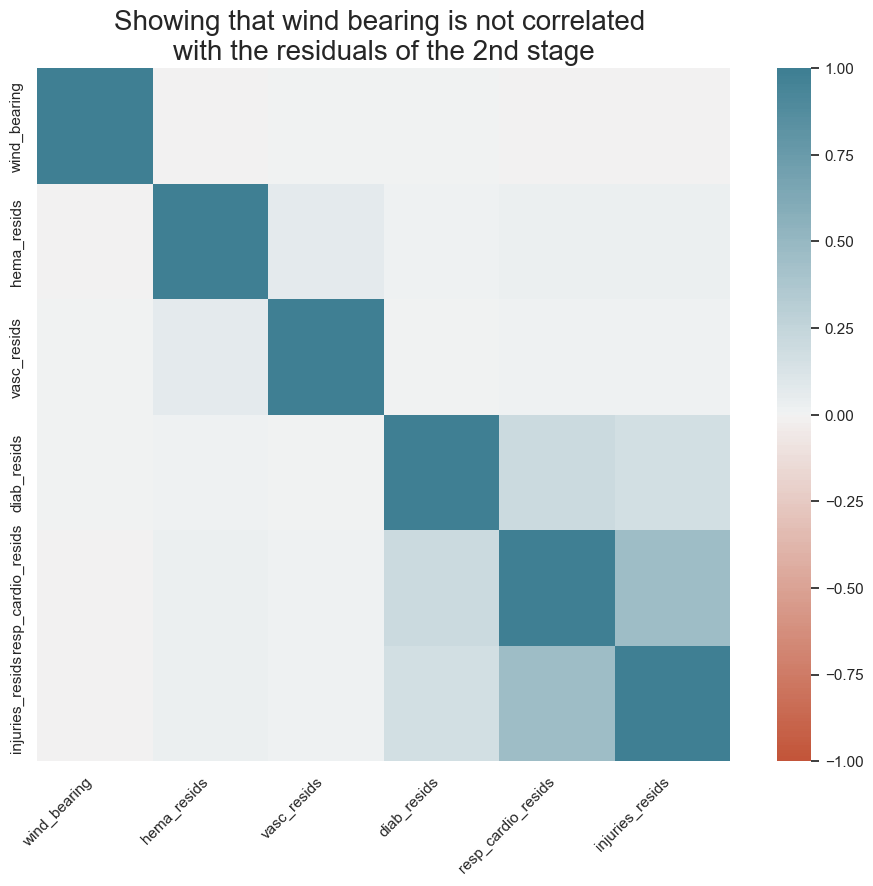

In [79]:
df_corr = pd.DataFrame({
  'wind_bearing': df_model[predictor_name_s1].values, 
  'hema_resids': resids_and_fitted_hema.resids.values,
  'vasc_resids': resids_and_fitted_vasc.resids.values, 
  'diab_resids': resids_and_fitted_diab.resids.values,
  'resp_cardio_resids': resids_and_fitted_resp_cardio.resids.values,
  'injuries_resids': resids_and_fitted_injuries.resids.values
}).corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Showing that wind bearing is not correlated \nwith the residuals of the 2nd stage", fontdict = {"fontsize": 20})
print('')

print(df_corr)

# First stage F-test

Run an F test with our instrument to study the impact on the pm2.5. 

In [80]:
# get data into right model form
y, X_null = dmatrices(f'{target_name_s1} ~ 1', data=df_model, return_type='dataframe')
y, X_instrument = dmatrices(f'{target_name_s1} ~ 1 + {predictor_name_s1}', data=df_model, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

from statsmodels.stats.anova import anova_lm
anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,255436.0,4.690376e+06,0.0,NaN,NaN,NaN
1,255435.0,4.688531e+06,1.0,1844.849817,100.508931,1.190584e-23


# Distribution Plots
- These are not yet updated with the additional two diagnosis groups

The disease distributions all on one plot are too hard to visualize.

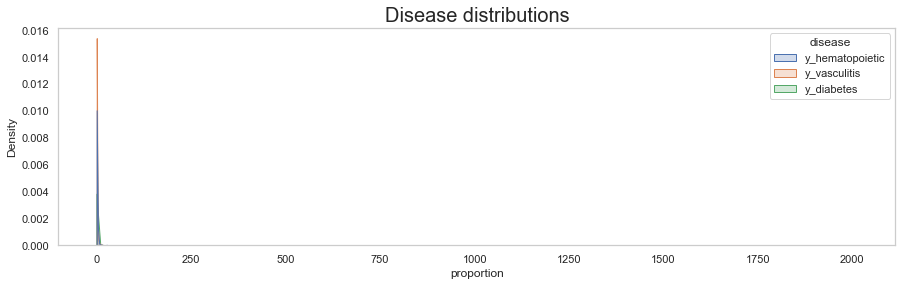

In [25]:
df_melt = pd.melt(df, 
              value_vars=['y_hematopoietic', 'y_vasculitis', 'y_diabetes'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Disease distributions", size=20)
print('')

The plot of each disease individually is too hard to see also due to inflated 0's.

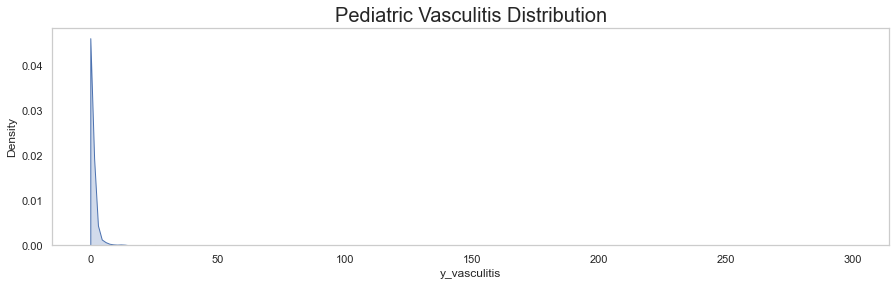

In [26]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="y_vasculitis", bw_adjust=.8, fill=True)\
  .set_title("Pediatric Vasculitis Distribution", size=20)
print('')

Each disease distribution is heavily skewed left, with most values very close to 0. 

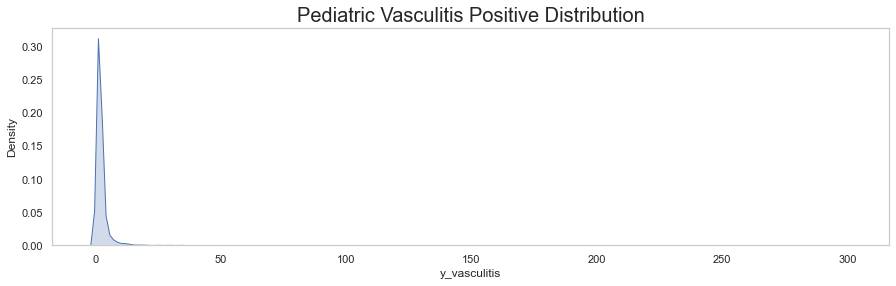

In [27]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True)\
  .set_title("Pediatric Vasculitis Positive Distribution", size=20)
print('')

Plotting the log of each disease distribution, looking at positive cases only is much easier to visualize:

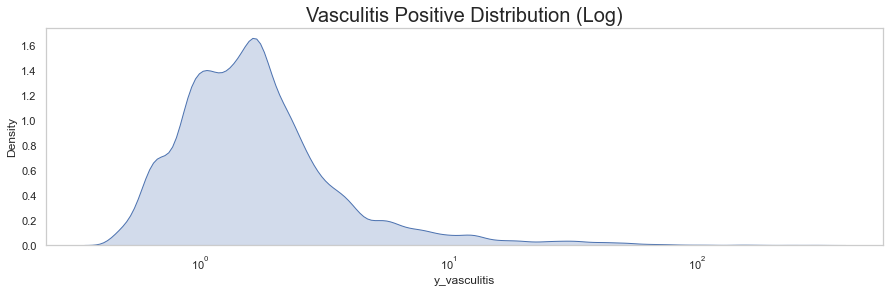

In [28]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Vasculitis Positive Distribution (Log)", size=20)
print('')

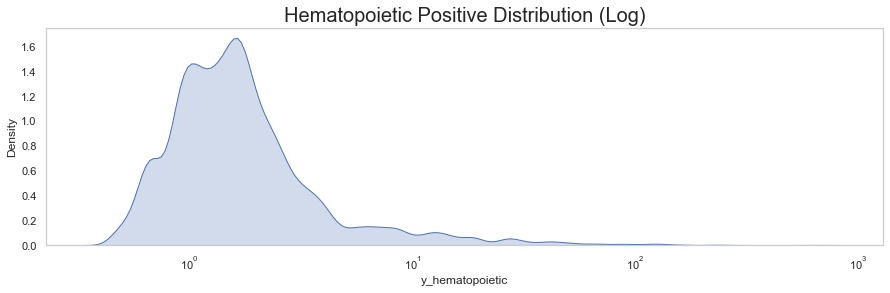

In [29]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_hematopoietic']>0], x="y_hematopoietic", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Hematopoietic Positive Distribution (Log)", size=20)
print('')

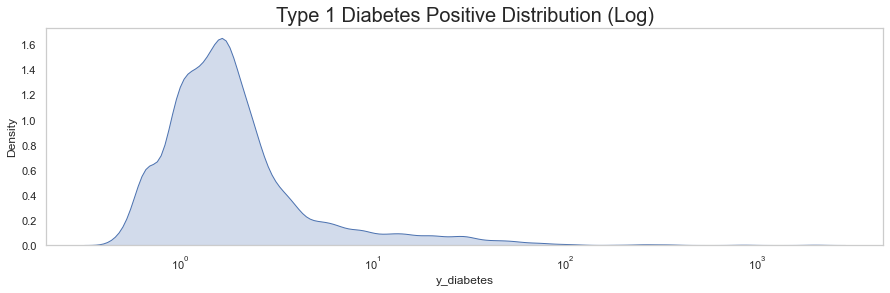

In [30]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_diabetes']>0], x="y_diabetes", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Type 1 Diabetes Positive Distribution (Log)", size=20)
print('')

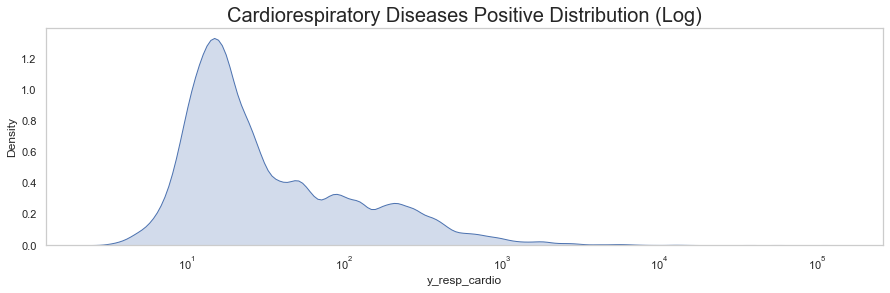

In [31]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_resp_cardio']>0], x="y_resp_cardio", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Cardiorespiratory Diseases Positive Distribution (Log)", size=20)
print('')

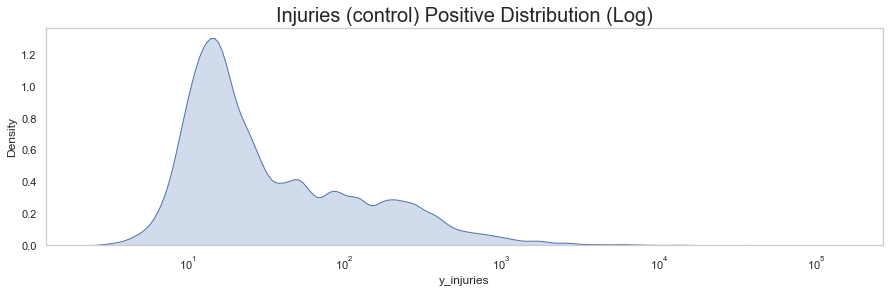

In [32]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_injuries']>0], x="y_injuries", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Injuries (control) Positive Distribution (Log)", size=20)
print('')

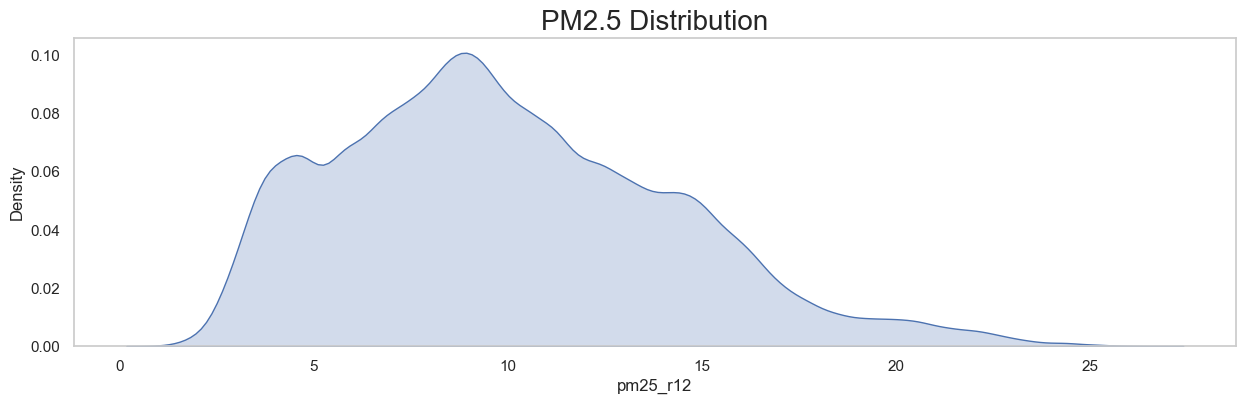

In [84]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_model, x=target_name_s1, bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Distribution", size=20)
print('')

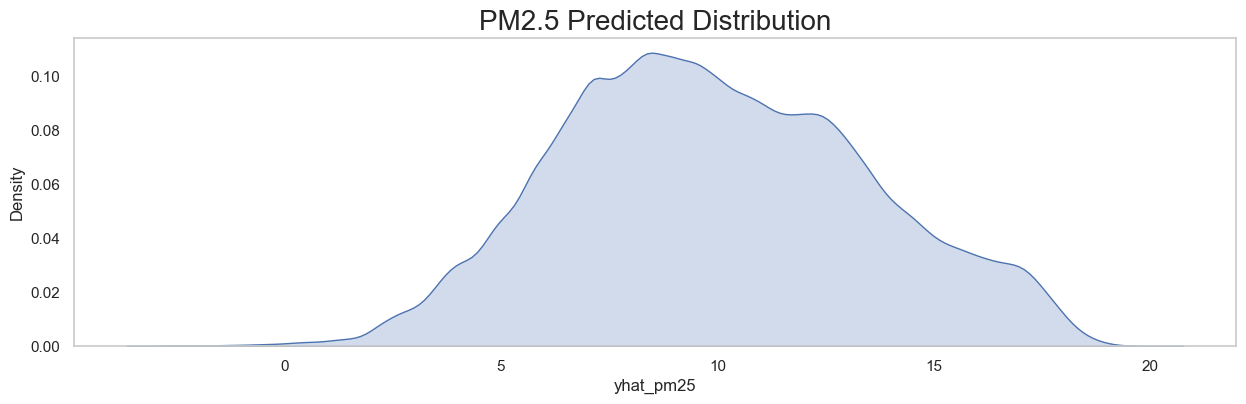

In [81]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_model, x="yhat_pm25", bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Predicted Distribution", size=20)
print('')

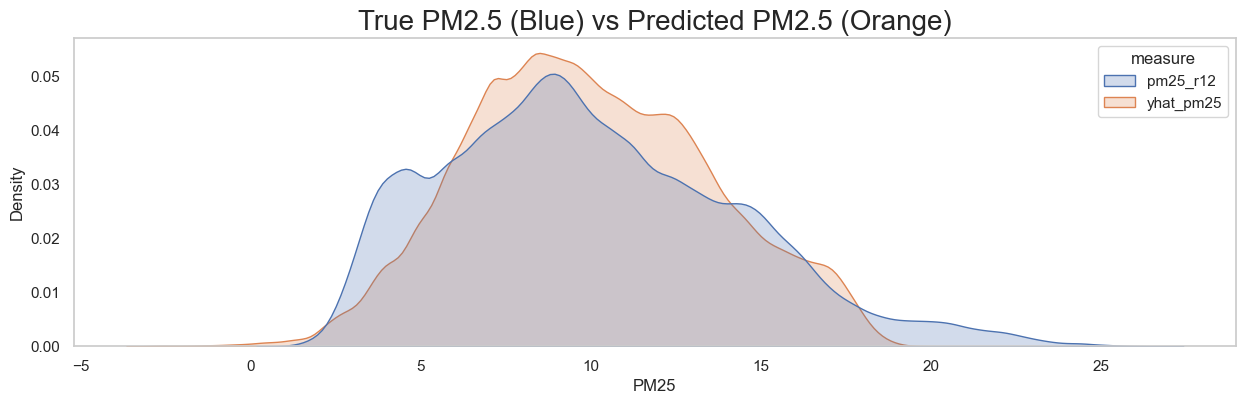

In [82]:
df_melt = pd.melt(df_model, 
              value_vars=[target_name_s1, 'yhat_pm25'], 
              var_name='measure', value_name='PM25')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="PM25", hue='measure', bw_adjust=.8, fill=True)\
  .set_title("True PM2.5 (Blue) vs Predicted PM2.5 (Orange)", size=20)
print('')

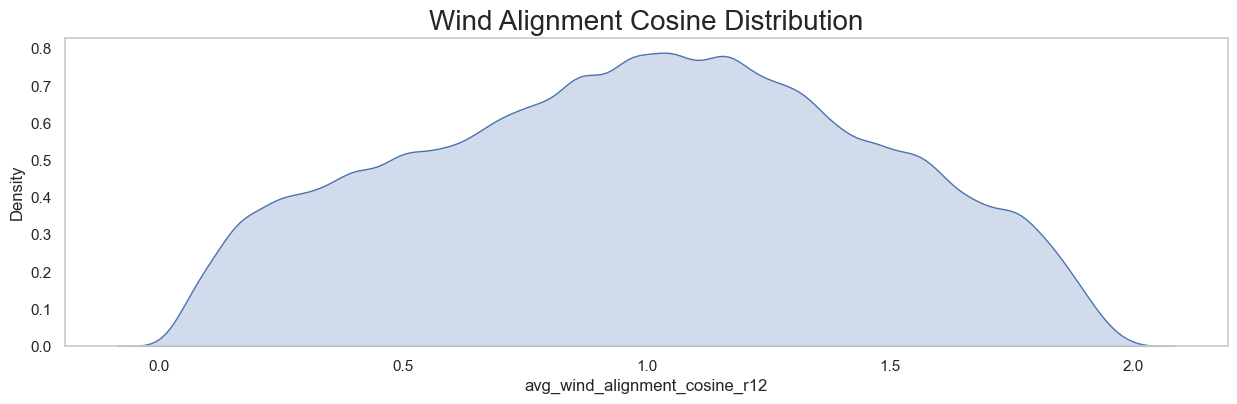

In [83]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_model, x=predictor_name_s1, bw_adjust=.8, fill=True)\
  .set_title("Wind Alignment Cosine Distribution", size=20)
print('')